
### Randomization Test Experiment 
* One of the key findings of the paper is that deep neural networks easily fit random noise. To validate this, we are training a neural network on a dataset where the labels are randomly assigned and evaluate its performance on the original test set.The random label test can be performed in two ways:
    
    * Complete label shuffle: The labels are shuffled completely and the network is trained on the shuffled labels. The network is then evaluated on the original test set.
    * Shuffled pixels : The pixels of all the images are permuted using a single random permutation and the network is trained on the shuffled dataset. The network is then evaluated on the original test set.
    * Random Pixels : The pixels of all the images are replaced with random values and the network is trained on the shuffled dataset. The network is then evaluated on the original test set.
    * Gaussian Noise : The pixels of all the images are replaced with random values drawn from a Gaussian distribution and the network is trained on the shuffled dataset. The network is then evaluated on the original test set.
    



In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import time
from torchsummary import summary
from tqdm import tqdm
import tensorflow
import tensorflow as tf
from sklearn.metrics import accuracy_score
from google.colab import drive
drive.mount('/content/drive')
import pickle
path = "/content/drive/MyDrive/savepickle/"


Mounted at /content/drive


In [3]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameter
batch_size = 64
#  CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor(),transforms.CenterCrop(28),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_dataset = torchvision.datasets.CIFAR10(root='./', train=True, download=True, transform=transform)
test_dataset =  torchvision.datasets.CIFAR10(root='./', train=False, transform=transform)

100%|██████████| 170498071/170498071 [00:02<00:00, 67875334.08it/s]


Extracting ./cifar-10-python.tar.gz to ./


In [4]:



for i in range(len(train_dataset)):
        train_dataset.data[i] = tf.image.per_image_standardization(train_dataset.data[i])
for i in range(len(test_dataset)):
        test_dataset.data[i] = tf.image.per_image_standardization(test_dataset.data[i])
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=32, shuffle=True, num_workers=2)
test_loader =  torch.utils.data.DataLoader(test_dataset,batch_size=32, shuffle=False, num_workers=2)
# size of the dataset
print(train_loader.dataset.data.shape)
print(test_loader.dataset.data.shape)


(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [7]:
class ConvModule(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(ConvModule, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(True)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        return out
    

class InceptionModule(nn.Module):
    def __init__(self, in_channels, Ch1x1 , Ch3x3):
        super(InceptionModule, self).__init__()
        self.branch1 = ConvModule(in_channels, Ch1x1, kernel_size=1, stride=1, padding=0)
        self.branch2 = ConvModule(in_channels, Ch3x3, kernel_size=3, stride=1, padding=1)
    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        return torch.cat([branch1, branch2], 1)
    
class DownsampleModule(nn.Module):
    def __init__(self, in_channels, Ch3x3):
        super(DownsampleModule, self).__init__()
        self.branch1 = ConvModule(in_channels, Ch3x3, kernel_size=3, stride=2, padding=0)
        self.branch2 = nn.MaxPool2d(3, stride=2)
    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        return torch.cat([branch1, branch2], 1)

class InceptionNet(nn.Module):
    def __init__(self, classes=10):
        super(InceptionNet, self).__init__()
        self.conv1 = ConvModule(in_channels=3, out_channels=96 , kernel_size=3, stride=1, padding=0)
        self.inception1 = InceptionModule(in_channels=96, Ch1x1=32 , Ch3x3=32)
        self.inception2 = InceptionModule(in_channels=64, Ch1x1=32 , Ch3x3=48)
        self.downsample1 = DownsampleModule(in_channels=80, Ch3x3=80)
        self.inception3 = InceptionModule(in_channels=160, Ch1x1=112 , Ch3x3=48)
        self.inception4 = InceptionModule(in_channels=160, Ch1x1=96 , Ch3x3=64)
        self.inception5 = InceptionModule(in_channels=160, Ch1x1=80 , Ch3x3=80)
        self.inception6 = InceptionModule(in_channels=160, Ch1x1=48 , Ch3x3=96)
        self.downsample2 = DownsampleModule(in_channels=144, Ch3x3=96)
        self.inception7 = InceptionModule(in_channels=240, Ch1x1=176 , Ch3x3=160)
        self.inception8 = InceptionModule(in_channels=336, Ch1x1=176 , Ch3x3=160)
        self.mean_pool = nn.AdaptiveAvgPool2d((7 , 7))
        self.fc = nn.Linear(16464, classes)
    def forward(self, x):
        out = self.conv1(x)
        out = self.inception1(out)
        out = self.inception2(out)
        out = self.downsample1(out)
        out = self.inception3(out)
        out = self.inception4(out)
        out = self.inception5(out)
        out = self.inception6(out)
        out = self.downsample2(out)
        out = self.inception7(out)
        out = self.inception8(out)
        out = self.mean_pool(out)
        out = torch.flatten(out,1)
        out = self.fc(out)
        return out

In [9]:

def LabelCorruption(percentage,myloader):
    labels = myloader.dataset.targets[:]
    data = myloader.dataset.data
    num = int(len(labels)*percentage)
    idxes = []
    if percentage == 1:
        idxes = list(range(len(labels)))
    while len(idxes) < num:
        idx = np.random.randint(0,len(labels))
        if idx not in idxes:
            idxes.append(idx)
    for idx in idxes:
        randomLabel = np.random.randint(0,10)
        while randomLabel == labels[idx]:
            randomLabel = np.random.randint(0,10)
        labels[idx] = randomLabel
    corrupted_dataset = torchvision.datasets.CIFAR10(root='./', train=True, download=True, transform=transform)
    corrupted_dataset.data = data
    corrupted_dataset.targets = labels
    corrupted_loader = torch.utils.data.DataLoader(dataset=corrupted_dataset, batch_size=batch_size, shuffle=True)
    return corrupted_loader



In [10]:

def accuracy(output , labels):
    output = output.to(device)
    labels = labels.to(device)
    _, predicted = torch.max(output.data, 1)
    total = labels.size(0)
    correct = (predicted == labels).sum().item()
    return correct / total


def getGaussianNoise(images , mean , std):
    n = images.size(0)
    c = images.size(1)
    h = images.size(2)
    w = images.size(3)
    # gaussian noise distribution with mean and var same as dataset
    mean = np.tile(mean, (n, h, w, 1)).transpose((0, 3, 1, 2))
    std = np.tile(std, (n, h, w, 1)).transpose((0, 3, 1, 2))
    
    noiseimages = np.random.normal(mean, std, (n,c,h,w))
    noiseimages = torch.from_numpy(noiseimages)
    noiseimages = noiseimages.float()
    noiseimages = noiseimages.to(device)
    return noiseimages

def getMeanVar(train_loader):
    mean = 0.0
    std = 0.0
    total = 0
    for data, _ in tqdm(train_loader):
         n = data.size(0)
         data = data.view(n, data.size(1), -1)
         mean += data.mean(2).sum(0)
         std += data.std(2).sum(0)
         total += n
    mean /= total
    std /= total
    return mean , std

 



def train(train_loader,epochs , randomLabel=False ,permutePixel = False ,randomPixel=False , GaussianNoise=False):
    model = InceptionNet().to(device)
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.95)

    train_loss = []
    train_acclst = []
    everyitr_loss = []
    # perm = torch.randperm(3072)
    itr = 0
    if randomLabel:
        train_loader = LabelCorruption(1,train_loader)

    if GaussianNoise:
        mue , var = getMeanVar(train_loader)
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        total = 0
        correct = 0
        for i, (images, labels) in enumerate(tqdm(train_loader)):
            images = images.to(device)
            labels = labels.to(device)
            outputs = None
            if randomPixel:
                randomImages = torch.rand(images.size()).to(device)
                outputs = model(randomImages)
            elif permutePixel:
                imagescpu = images.cpu().numpy()
                permutatefunc = np.random.default_rng(32)
                permuteImages = permutatefunc.permutation(imagescpu,axis = 2)
                permuteImages = torch.from_numpy(permuteImages).to(device)
                outputs = model(permuteImages)
            elif GaussianNoise:
                 gaussianImages = getGaussianNoise(images , mue , var)
                 outputs = model(gaussianImages)
            else:
                outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            total += labels.size(0)
            everyitr_loss.append(running_loss/total)
            correct += (outputs.argmax(1) == labels).sum().item()

        train_loss.append(running_loss/total)
        train_acclst.append(correct/total)
        # print("Epoch" , epoch , "Train Loss" , running_loss/total)
        scheduler.step()  
    return train_loss, model, train_acclst, everyitr_loss

In [11]:
RandomLabeltrainloss , RandomLabelNet , RandomLabeltrainacc, RandomLabeleveryitr_loss = train(train_loader, 50, randomLabel=True)
RandomPixeltrainloss , RandomPixelNet , RandomPixeltrainacc, RandomPixeleveryitr_loss = train(train_loader, 50, randomPixel=True)
PermutedPixeltrainloss , PermutedPixelNet , PermutedPixeltrainacc, PermutedPixeleveryitr_loss = train(train_loader, 50, permutePixel=True)
GaussianNoisetrainloss , GaussianNoiseNet , GaussianNoisetrainacc, GaussianNoiseeveryitr_loss = train(train_loader, 50, GaussianNoise=True)



Files already downloaded and verified


100%|██████████| 1563/1563 [00:46<00:00, 33.96it/s]


In [22]:
# RandomLabeltrainloss , RandomLabelNet , RandomLabeltrainacc, RandomLabeleveryitr_loss = train(train_loader, test_loader, 1, randomLabel=True)
Correcttrainloss , CorrectNet, Correcttrainacc, Correcteveryitr_loss = train(train_loader, 50)


100%|██████████| 1563/1563 [00:38<00:00, 41.08it/s]


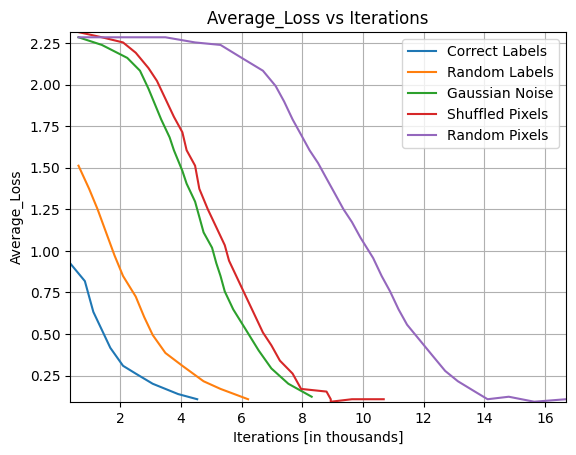

In [2]:

import matplotlib.pyplot as plt
import numpy as np
def scale_y_axis(data, min, max):
    data = np.array(data)
    data = (data - np.min(data)) / (np.max(data) - np.min(data))
    data = data * (max - min) + min
    return data


def get_x_axis(data):
    newdata = []
    for i in range(len(data)):
        newdata.append(i / 1000)
    return newdata


losses = {"Correct Labels": Correcteveryitr_loss,
          "Random Labels" : RandomLabeleveryitr_loss,
          "Random Pixels": RandomPixeltrainloss,
          "Shuffled Pixels": PermutedPixeltrainloss,
          "Gaussian Noise": GaussianNoisetrainloss}



def plot_loss_vs_epoch(losses):
    for key in losses:
        plt.plot(get_x_axis(losses[key]), scale_y_axis(losses[key]), label=key)
    plt.xlabel("Epochs")
    plt.ylabel("Average_Loss")
    plt.title("Average_Loss vs Epochs")
    plt.legend()
    plt.grid()
    plt.show()

plot_loss_vs_epoch(losses)



